In [1]:
from models.utils import load_model
# from robustbench.utils import clean_accuracy
# from robustbench.data import load_cifar10
# from robustbench.data import load_cifar10c
# from robustbench.data import load_cifar100c

In [2]:
# !pip install -q git+https://github.com/fra31/auto-attack
from autoattack import AutoAttack

# !pip install -q foolbox  # produces 2 incompatibility messages, but they can be just ignored
import foolbox as fb

In [2]:
model = load_model(model_name='Carmon2019Unlabeled', dataset="cifar10", threat_model='Linf')
#model = load_model(model_name="Kang2021Stable", threat_model="Linf")

Downloading...
From: https://drive.google.com/uc?id=15tUx-gkZMYx7BfEOw1GY5OKC-jECIsPQ
To: /cis/home/rmuthuk1/nonisotropic/models/pretrained/cifar10/robustbenchmark/Linf/Carmon2019Unlabeled.pt
100%|██████████| 153M/153M [00:02<00:00, 54.3MB/s] 


In [4]:
model

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNor

In [5]:
x_test, y_test = load_cifar10(n_examples=100)

Files already downloaded and verified


In [6]:
x_test.shape, y_test.shape

(torch.Size([100, 3, 32, 32]), torch.Size([100]))

In [7]:
x_testc, y_testc = load_cifar10c(n_examples=100)

Starting download from https://zenodo.org/api/records/2535967/files/CIFAR-10-C.tar/content


44533it [01:29, 499.75it/s]                           


Download finished, extracting...
Downloaded and extracted.


In [55]:
x_testc, y_testc = load_cifar100c(n_examples=100)

Starting download from https://zenodo.org/api/records/3555552/files/CIFAR-100-C.tar/content


44533it [01:34, 470.61it/s]                           


Download finished, extracting...
Downloaded and extracted.


In [56]:
x_testc.shape

torch.Size([100, 3, 32, 32])

In [8]:
model_fb = fb.PyTorchModel(model, bounds=(0, 1))
_, advs, success = fb.attacks.LinfPGD(rel_stepsize=0.1, steps=20)(model_fb, x_test.to('cuda:0'), y_test.to('cuda:0'), epsilons=[8/255])
print('Robust accuracy: {:.1%}'.format(1 - success.float().mean()))

/cis/home/rmuthuk1/anaconda3/envs/advrob/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712608885084/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


Robust accuracy: 61.0%


In [9]:
model.cuda()

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNor

In [10]:
adversary = AutoAttack(
    model,
    norm="Linf",
    eps=8 / 255,
    version="custom",
    attacks_to_run=["apgd-ce", "apgd-dlr"],
)
adversary.apgd.n_restarts = 1
x_adv = adversary.run_standard_evaluation(x_test, y_test)

using custom version including apgd-ce, apgd-dlr.
initial accuracy: 89.00%
apgd-ce - 1/1 - 34 out of 89 successfully perturbed
robust accuracy after APGD-CE: 55.00% (total time 22.1 s)
apgd-dlr - 1/1 - 2 out of 55 successfully perturbed
robust accuracy after APGD-DLR: 53.00% (total time 36.9 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 53.00%


In [53]:
x_adv

torch.Size([100, 3, 32, 32])

In [11]:
from threat_specification.greedy_subset import load_greedy_subset
from threat_specification.projected_displacement import (
    non_isotropic_projection,
    non_isotropic_threat,
)

In [12]:
from foundations import hparams

In [17]:
import platforms.platform as p 
import platforms.local as L

In [37]:
import argparse

In [39]:
import platforms.registry

In [40]:
runner_name = "test"

In [41]:
from cli import runner_registry

In [43]:
# Add the arguments for that command.
usage = "\n" + "\n"
usage += f"nonisotropic.py {runner_name} [...] => {runner_registry.get(runner_name).description()}"
usage += "\n" + "-" * 82 + "\n"


In [44]:
platform_name = "local"

In [46]:
parser = argparse.ArgumentParser(usage=usage, conflict_handler="resolve")
parser.add_argument("subcommand")
parser.add_argument(
        "--platform", default="local", help="The platform on which the job will run."
    )
parser.add_argument(
        "--display_output_location",
        action="store_true",
        help="Display the output location for this job.",
    )


_StoreTrueAction(option_strings=['--display_output_location'], dest='display_output_location', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='Display the output location for this job.', metavar=None)

In [47]:
platforms.registry.get(platform_name).add_args(parser)

In [48]:
from platforms.platform import get_platform

In [52]:
args = parser.parse_args()
print(args)

usage: 

nonisotropic.py test [...] => Test a trained model.
----------------------------------------------------------------------------------
ipykernel_launcher.py: error: the following arguments are required: subcommand


SystemExit: 2

In [ ]:
get_platform().torch_device

AttributeError: 'NoneType' object has no attribute 'torch_device'

In [35]:
print(L.Platform().create_from_args())

TypeError: create_from_args() missing 1 required positional argument: 'args'

In [13]:
dataset_hparams = hparams.DatasetHparams(
    dataset_name="cifar10",
    batch_size=256,
    num_labels=10,
    num_channels=3,
    num_spatial_dims=32,
)

In [ ]:
platform = 

In [14]:
greedy_subsets = load_greedy_subset(dataset_hparams)

AttributeError: 'NoneType' object has no attribute 'dataset_root'

In [13]:
adversary = AutoAttack(
    model,
    norm="Linf",
    eps=8 / 255
    )
x_adv = adversary.run_standard_evaluation(x_test, y_test)

setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 89.00%
apgd-ce - 1/1 - 33 out of 89 successfully perturbed
robust accuracy after APGD-CE: 56.00% (total time 13.2 s)
apgd-t - 1/1 - 3 out of 56 successfully perturbed
robust accuracy after APGD-T: 53.00% (total time 94.8 s)
fab-t - 1/1 - 0 out of 53 successfully perturbed
robust accuracy after FAB-T: 53.00% (total time 251.6 s)
square - 1/1 - 0 out of 53 successfully perturbed
robust accuracy after SQUARE: 53.00% (total time 469.8 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 53.00%


In [17]:
x_testc, y_testc = load_cifar10c(n_examples=100, corruptions=['gaussian_noise', 'shot_noise'], severity=3)
print((x_testc.shape, y_testc.shape))

for model_name in ['Standard', 'Engstrom2019Robustness', 'Rice2020Overfitting','Carmon2019Unlabeled']:
    model = load_model(model_name=model_name, dataset='cifar10', threat_model='Linf')
    acc = clean_accuracy(model, x_testc, y_testc)
    print(f'Model: {model_name}, CIFAR-10-C accuracy: {acc:.1%}')

(torch.Size([100, 3, 32, 32]), torch.Size([100]))
Model: Standard, CIFAR-10-C accuracy: 46.0%


Downloading...
From: https://drive.google.com/uc?id=1etqmQsksNIWBvBQ4r8ZFk_3FJlLWr8Rr
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Engstrom2019Robustness.pt
100%|██████████| 94.4M/94.4M [00:01<00:00, 69.4MB/s]


Model: Engstrom2019Robustness, CIFAR-10-C accuracy: 93.0%


Downloading...
From: https://drive.google.com/uc?id=1vC_Twazji7lBjeMQvAD9uEQxi9Nx2oG-
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Rice2020Overfitting.pt
100%|██████████| 738M/738M [00:08<00:00, 87.3MB/s] 


Model: Rice2020Overfitting, CIFAR-10-C accuracy: 91.0%
Model: Carmon2019Unlabeled, CIFAR-10-C accuracy: 92.0%


In [3]:
model_names = [
    "Peng2023Robust",
    "Wang2023Better_WRN-70-16",
    "Bai2024MixedNUTS",
    "Bai2023Improving_edm",
    "Cui2023Decoupled_WRN-28-10",	
    "Wang2023Better_WRN-28-10", 
    "Rebuffi2021Fixing_70_16_cutmix_extra",
    "Gowal2021Improving_70_16_ddpm_100m",
    "Gowal2020Uncovering_70_16_extra",
    "Huang2022Revisiting_WRN-A4",
    "Rebuffi2021Fixing_106_16_cutmix_ddpm",
    "Rebuffi2021Fixing_70_16_cutmix_ddpm",
    "Kang2021Stable",
    "Xu2023Exploring_WRN-28-10",
    "Gowal2021Improving_28_10_ddpm_100m"
]

In [33]:
for model_name in model_names:
    model = load_model(model_name=model_name, dataset="cifar10", threat_model="Linf")

Downloading...
From: https://drive.google.com/uc?id=1-6M8KHZdPmgqYkBSkdZQ2fLwp86ZQ9VU
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Peng2023Robust.pt
100%|██████████| 1.07G/1.07G [00:09<00:00, 117MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1-RF7ZSS-PAh6bfQcuqx4lh9bc9BUGnap
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Wang2023Better_WRN-70-16.pt
100%|██████████| 1.07G/1.07G [00:06<00:00, 156MB/s] 


The STD classifier has 232279184 parameters. 232279184 parameters are trainable.
The ROB classifier has 267240802 parameters. 267240802 parameters are trainable.
Using alpha=0.9987500602493457.
Using alpha_diffable=0.9570535356459247.
Bypassing robust base model nonlinear transformation for gradient calculations.
Disabling autocast.


Downloading...
From: https://drive.google.com/uc?id=1-5EwY_5tQZudo9idwXiUGr3P4OUUGaQN
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Bai2024MixedNUTS.pt_m0.pt
100%|██████████| 929M/929M [00:06<00:00, 133MB/s]  


Downloading...
From: https://drive.google.com/uc?id=1-6M8KHZdPmgqYkBSkdZQ2fLwp86ZQ9VU
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Bai2024MixedNUTS.pt_m1.pt
100%|██████████| 1.07G/1.07G [00:05<00:00, 181MB/s]


The STD classifier has 232279178 parameters. 0 parameters are trainable.
The ROB classifier has 266796506 parameters. 0 parameters are trainable.
The mixing network has 67848704 parameters. 67848704 parameters are trainable.

gamma has been set to 2.5, but the mixing network is active so the change is not effective.
gamma has been set to 3.0, but the mixing network is active so the change is not effective.
The mixing network's gamma mean is set to 1.0499999523162842.
The mixing network's gamma standard deviation is set to 2.0.
The range of alpha during evaluation is set to (0.9599999785423279, 1.0).
The logit output scale of the STD network is set to 1.2000000476837158.
The logit output scale of the ROB network is set to 0.30000001192092896.



Downloading...
From: https://drive.google.com/uc?id=1-5EwY_5tQZudo9idwXiUGr3P4OUUGaQN
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Bai2023Improving_edm.pt_m0.pt
100%|██████████| 929M/929M [00:05<00:00, 185MB/s]  


Downloading...
From: https://drive.google.com/uc?id=1-RF7ZSS-PAh6bfQcuqx4lh9bc9BUGnap
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Bai2023Improving_edm.pt_m1.pt
100%|██████████| 1.07G/1.07G [00:05<00:00, 205MB/s]


Downloading...
From: https://drive.google.com/uc?id=1-7oV7QDgz8McvhbaCj6Owx3Rz3daiPrT
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Bai2023Improving_edm.pt_m2.pt
100%|██████████| 271M/271M [00:03<00:00, 77.5MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1-AaTrYt23WJFR22hXgBd-i6kjpsz6Hf2
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Cui2023Decoupled_WRN-28-10.pt
100%|██████████| 146M/146M [00:02<00:00, 56.7MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1-6MYKJdECDVGaWjj6GgqvaT95BGKhUvI
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Wang2023Better_WRN-28-10.pt
100%|██████████| 146M/146M [00:00<00:00, 170MB/s]  


Downloading...
From: https://drive.google.com/uc?id=1qKDTp6IJ1BUXZaRtbYuo_t0tuDl_4mLg
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Rebuffi2021Fixing_70_16_cutmix_extra.pt
100%|██████████| 1.07G/1.07G [00:07<00:00, 136MB/s] 


Downloading...
From: https://drive.google.com/uc?id=10qBoDG_NomJBrRFeTsSwEcJF1GA-sjC4
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Gowal2021Improving_70_16_ddpm_100m.pt
100%|██████████| 1.07G/1.07G [00:04<00:00, 225MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1GxryYj_Or-VCDca0wgiFLz4ssXSZXQoJ
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Gowal2020Uncovering_70_16_extra.pt
100%|██████████| 1.07G/1.07G [00:11<00:00, 95.2MB/s]


Downloading...
From: https://drive.google.com/uc?id=1okHk4XPgunmqHG3alXfVF84qRwlu6Oqe
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Huang2022Revisiting_WRN-A4.pt
100%|██████████| 590M/590M [00:05<00:00, 107MB/s]  


Downloading...
From: https://drive.google.com/uc?id=1-4qnkveIkeWoGdF72kpEFHETiY3y4_tF
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Rebuffi2021Fixing_106_16_cutmix_ddpm.pt
100%|██████████| 1.66G/1.66G [00:07<00:00, 214MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1-8CWRT-OFWyrz4T4s0I2mbFjPg8K_MUi
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Rebuffi2021Fixing_70_16_cutmix_ddpm.pt
100%|██████████| 1.07G/1.07G [00:21<00:00, 49.6MB/s]


Downloading...
From: https://drive.google.com/uc?id=1-HjG9f7wJDnNRdMQSiz8dlCI3sq5mfqj
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Kang2021Stable.pt
100%|██████████| 1.07G/1.07G [00:25<00:00, 42.6MB/s]


Downloading...
From: https://drive.google.com/uc?id=1k1uJI13ft0h0dfzuEihVpBvjBXwFRH2o
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Xu2023Exploring_WRN-28-10.pt
100%|██████████| 146M/146M [00:02<00:00, 54.0MB/s] 


Downloading...
From: https://drive.google.com/uc?id=12L8YE6VBgUDKyW6GMSNefSYj2gg4LEKx
To: /cis/home/rmuthuk1/nonisotropic/models/cifar10/Linf/Gowal2021Improving_28_10_ddpm_100m.pt
100%|██████████| 146M/146M [00:02<00:00, 54.1MB/s] 


In [26]:
x_test, y_test = load_cifar10(n_examples=500)
x_test, y_test = x_test.to("cuda:9"), y_test.to("cuda:9")

x_adv = None

print("Evaluating pretrained models on CIFAR10")
for model_name in model_names[4:]:
    print(f"\n Evaluating Model: {model_name}")
    model = load_model(model_name=model_name, dataset="cifar10", threat_model="Linf")
    model = model.to("cuda:9")
    acc = clean_accuracy(model, x_test, y_test)
    print(f"Clean accuracy: {acc:.1%}")
    adversary = AutoAttack(
        model,
        norm="Linf",
        eps=20 / 255,
        version="custom",
        attacks_to_run=["apgd-ce"],  # "apgd-dlr"
        verbose=False,
        device="cuda:9",
    )
    adversary.apgd.n_restarts = 1
    x_adv = adversary.run_standard_evaluation(x_test, y_test)
    x_adv = x_adv.to("cuda:9")
    robust_acc = clean_accuracy(model, x_adv, y_test)
    print(f"Robust accuracy: {robust_acc:.1%}")
    break 

Files already downloaded and verified
Evaluating pretrained models on CIFAR10

 Evaluating Model: Cui2023Decoupled_WRN-28-10
Clean accuracy: 93.2%
Robust accuracy: 14.4%


In [29]:
def plot_images(images, labels, num_images=4, random_start=False):
    assert len(images) == len(labels)
    num_data = len(images)
    start = 10
    if random_start:
        start = torch.randint(0, num_data - num_images - 1, (1,)).item()

    label_str = ""
    classes = (
        "plane",
        "car",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    )
    for i in range(num_images):
        label_str += classes[labels[start + i].item()] + "\n"
        # label_str += label_dict[labels[start + i].item()] + "\n"
    print(label_str)

    img_select = images[start : start + num_images]
    for i in range(num_images):
        img_min = img_select[i].min()
        img_max = img_select[i].max()
        img_select[i].clamp_(min=img_min, max=img_max)
        img_select[i].add_(-img_min).div_(img_max - img_min + 1e-5)
    img = torchvision.utils.make_grid(img_select, nrow=num_images)

    if img.is_cuda:
        img = img.cpu()

    plt.figure(figsize=(12, 12))
    plt.imshow(img.permute(1, 2, 0))

In [16]:
import torch

import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode

import numpy as np
import matplotlib.pyplot as plt

plane
truck
dog
horse



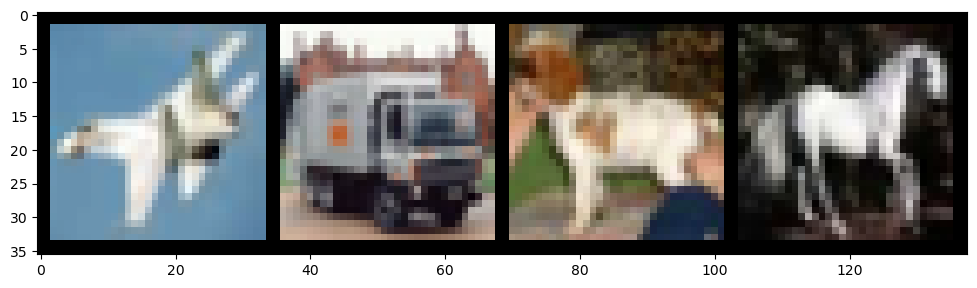

In [30]:
plot_images(x_test, y_test)

plane
truck
dog
horse



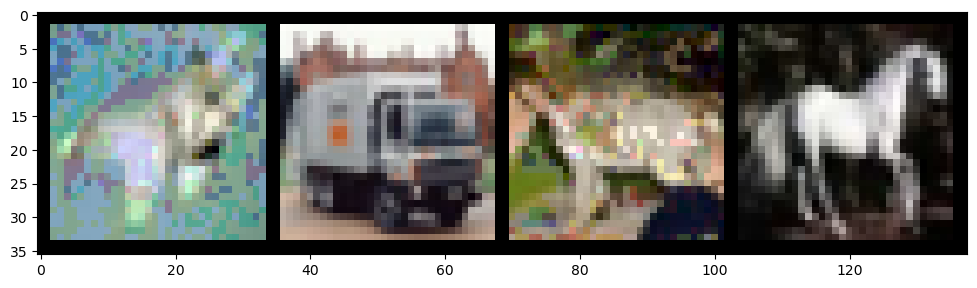

In [31]:
plot_images(x_adv, y_test)

In [28]:
cifar100_model_names = [
    "Wang2023Better_WRN-70-16",
    "Bai2024MixedNUTS",
    "Cui2023Decoupled_WRN-28-10",
    "Wang2023Better_WRN-28-10",
    "Bai2023Improving_edm",
    "Gowal2020Uncovering_extra",
    "Bai2023Improving_trades",
    "Debenedetti2022Light_XCiT-L12",
    "Rebuffi2021Fixing_70_16_cutmix_ddpm",
    "Debenedetti2022Light_XCiT-M12",
    "Pang2022Robustness_WRN70_16",
    "Cui2023Decoupled_WRN-34-10_autoaug",
    "Debenedetti2022Light_XCiT-S12",
    "Rebuffi2021Fixing_28_10_cutmix_ddpm",
    "Jia2022LAS-AT_34_20",
]

In [29]:
for model_name in cifar100_model_names:
    model = load_model(model_name=model_name, dataset="cifar100", threat_model="Linf")

Downloading...
From: https://drive.google.com/uc?id=1-yYcT73GP13c0y9HrgtpyB3NAfkGKgjY
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Wang2023Better_WRN-70-16.pt
100%|██████████| 1.07G/1.07G [00:07<00:00, 138MB/s] 


The STD classifier has 232647914 parameters. 232647914 parameters are trainable.
The ROB classifier has 266888756 parameters. 266888756 parameters are trainable.
Using alpha=0.9860300534207915.
Using alpha_diffable=0.9706995384302841.
Bypassing robust base model nonlinear transformation for gradient calculations.
Disabling autocast.


Downloading...
From: https://drive.google.com/uc?id=1V7utaY3SyU65o6ivjidG1-wO5wAVF517
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Bai2024MixedNUTS.pt_m0.pt
100%|██████████| 931M/931M [00:05<00:00, 177MB/s]  


Downloading...
From: https://drive.google.com/uc?id=1-yYcT73GP13c0y9HrgtpyB3NAfkGKgjY
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Bai2024MixedNUTS.pt_m1.pt
100%|██████████| 1.07G/1.07G [00:07<00:00, 137MB/s] 


Downloading...
From: https://drive.google.com/uc?id=15BwWdWbNfoarTEWWugicOVkTjh3nXH36
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Cui2023Decoupled_WRN-28-10.pt
100%|██████████| 146M/146M [00:02<00:00, 71.3MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1-jOu3wKWyw0XnBCXDGR32xn8Bw9GTJgh
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Wang2023Better_WRN-28-10.pt
100%|██████████| 146M/146M [00:01<00:00, 118MB/s]  


The STD classifier has 232647908 parameters. 0 parameters are trainable.
The ROB classifier has 266888756 parameters. 0 parameters are trainable.
The mixing network has 67848704 parameters. 67848704 parameters are trainable.

gamma has been set to 2.5, but the mixing network is active so the change is not effective.
The mixing network's gamma mean is set to 1.2999999523162842.
The mixing network's gamma standard deviation is set to 2.0.
The range of alpha during evaluation is set to (0.8399999737739563, 0.9900000095367432).
The logit output scale of the STD network is set to 2.0.
The logit output scale of the ROB network is set to 1.0.



Downloading...
From: https://drive.google.com/uc?id=12Z63xr4bQwdIvR2w8xvpUnXG1fnUpy5B
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Bai2023Improving_edm.pt_m0.pt
100%|██████████| 931M/931M [00:05<00:00, 159MB/s]  


Downloading...
From: https://drive.google.com/uc?id=1-yYcT73GP13c0y9HrgtpyB3NAfkGKgjY
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Bai2023Improving_edm.pt_m1.pt
100%|██████████| 1.07G/1.07G [00:08<00:00, 126MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1--8Jd82Q9ZLlVS_6c1iPrBxqy9sbdAkx
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Bai2023Improving_edm.pt_m2.pt
100%|██████████| 814M/814M [00:06<00:00, 120MB/s]  


Downloading...
From: https://drive.google.com/uc?id=1LQBdwO2b391mg7VKcP6I0HIOpC6O83gn
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Gowal2020Uncovering_extra.pt
100%|██████████| 1.07G/1.07G [00:11<00:00, 92.8MB/s]


The STD classifier has 232647908 parameters. 0 parameters are trainable.
The ROB classifier has 266888756 parameters. 0 parameters are trainable.
The mixing network has 67848704 parameters. 67848704 parameters are trainable.

gamma has been set to 1.75, but the mixing network is active so the change is not effective.
The mixing network's gamma mean is set to 1.0.
The mixing network's gamma standard deviation is set to 2.0.
The range of alpha during evaluation is set to (0.8149999976158142, 0.9150000214576721).
The logit output scale of the STD network is set to 2.0.
The logit output scale of the ROB network is set to 1.0.



Downloading...
From: https://drive.google.com/uc?id=12Z63xr4bQwdIvR2w8xvpUnXG1fnUpy5B
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Bai2023Improving_trades.pt_m0.pt
100%|██████████| 931M/931M [00:05<00:00, 163MB/s]  


Downloading...
From: https://drive.google.com/uc?id=1LQBdwO2b391mg7VKcP6I0HIOpC6O83gn
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Bai2023Improving_trades.pt_m1.pt
100%|██████████| 1.07G/1.07G [00:05<00:00, 193MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1-0Sffx4gCIydJc16n1H0k6FYE4kHRnGm
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Bai2023Improving_trades.pt_m2.pt
100%|██████████| 814M/814M [00:06<00:00, 119MB/s]  
Downloading: "https://github.com/RobustBench/robustbench/releases/download/v1.1/debenedetti2022light-xcit-l-cifar100-linf.pth.tar" to /cis/home/rmuthuk1/.cache/torch/hub/checkpoints/debenedetti2022light-xcit-l-cifar100-linf.pth.tar


Downloading...
From: https://drive.google.com/uc?id=1-GkVLo9QaRjCJl-by67xda1ySVhYxsLV
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Rebuffi2021Fixing_70_16_cutmix_ddpm.pt
100%|██████████| 1.07G/1.07G [00:15<00:00, 69.9MB/s]
Downloading: "https://github.com/RobustBench/robustbench/releases/download/v1.1/debenedetti2022light-xcit-m-cifar100-linf.pth.tar" to /cis/home/rmuthuk1/.cache/torch/hub/checkpoints/debenedetti2022light-xcit-m-cifar100-linf.pth.tar


Downloading...
From: https://drive.google.com/uc?id=1F3kn8KIdBVls8QuTWc3BbB83htkQeVQD
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Pang2022Robustness_WRN70_16.pt
100%|██████████| 1.07G/1.07G [00:11<00:00, 90.4MB/s]


Downloading...
From: https://drive.google.com/uc?id=18hjcLa1V3JTNUOshafLvw1ncxL2gu50M
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Cui2023Decoupled_WRN-34-10_autoaug.pt
100%|██████████| 185M/185M [00:01<00:00, 110MB/s]  
Downloading: "https://github.com/RobustBench/robustbench/releases/download/v1.1/debenedetti2022light-xcit-s-cifar100-linf.pth.tar" to /cis/home/rmuthuk1/.cache/torch/hub/checkpoints/debenedetti2022light-xcit-s-cifar100-linf.pth.tar


Downloading...
From: https://drive.google.com/uc?id=1-P7cs82Tj6UVx7Coin3tVurVKYwXWA9p
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Rebuffi2021Fixing_28_10_cutmix_ddpm.pt
100%|██████████| 146M/146M [00:02<00:00, 62.1MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1WhRq01Yl1v8O3skkrGUBuySlptidc5a6
To: /cis/home/rmuthuk1/nonisotropic/models/cifar100/Linf/Jia2022LAS-AT_34_20.pt
100%|██████████| 739M/739M [00:08<00:00, 90.8MB/s] 


In [30]:
imagenet_model_names = [
    "Liu2023Comprehensive_Swin-L",
    "Bai2024MixedNUTS",
    "Liu2023Comprehensive_ConvNeXt-L",
    "Singh2023Revisiting_ConvNeXt-L-ConvStem",
    "Liu2023Comprehensive_Swin-B",
    "Singh2023Revisiting_ConvNeXt-B-ConvStem",
    "Liu2023Comprehensive_ConvNeXt-B",
    "Singh2023Revisiting_ViT-B-ConvStem",
    "Singh2023Revisiting_ConvNeXt-S-ConvStem",
    "Singh2023Revisiting_ConvNeXt-T-ConvStem",
    "Peng2023Robust",
    "Singh2023Revisiting_ViT-S-ConvStem",
    "Debenedetti2022Light_XCiT-L12",
    "Debenedetti2022Light_XCiT-M12",
    "Debenedetti2022Light_XCiT-S12",
]

In [31]:
for model_name in imagenet_model_names:
    model = load_model(model_name=model_name, dataset="imagenet", threat_model="Linf")

Downloading...
From: https://drive.google.com/uc?id=1-57sQfcrsDsslfDR18nRD7FnpQmsSBk7
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Liu2023Comprehensive_Swin-L.pt
100%|██████████| 788M/788M [00:12<00:00, 62.5MB/s] 


The STD classifier has 197956846 parameters. 197956846 parameters are trainable.
The ROB classifier has 196532476 parameters. 196532476 parameters are trainable.
Using alpha=0.9971266414518896.
Using alpha_diffable=0.90683792395046.
Bypassing robust base model nonlinear transformation for gradient calculations.
Disabling autocast.


Downloading...
From: https://drive.google.com/uc?id=1-2CwsRuMZXr99PeU2Z7-iFjl_86uIR-Y
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Bai2024MixedNUTS.pt_m0.pt
100%|██████████| 792M/792M [00:09<00:00, 80.0MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1-57sQfcrsDsslfDR18nRD7FnpQmsSBk7
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Bai2024MixedNUTS.pt_m1.pt
100%|██████████| 788M/788M [00:08<00:00, 92.5MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1dIPLNfdQtAnqZrKPyuy3_zDI-FVgJ2FH
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Liu2023Comprehensive_ConvNeXt-L.pt
100%|██████████| 791M/791M [00:07<00:00, 101MB/s]  


Downloading...
From: https://drive.google.com/uc?id=10-YOVdM2EQjHemSi9x2H44qKRSOXVQmh
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Singh2023Revisiting_ConvNeXt-L-ConvStem.pt
100%|██████████| 793M/793M [00:06<00:00, 129MB/s]  


Downloading...
From: https://drive.google.com/uc?id=1-4mtxQCkThJUVdS3wvQ6NnmMZuySqR3c
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Liu2023Comprehensive_Swin-B.pt
100%|██████████| 353M/353M [00:05<00:00, 62.1MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1-lE-waaVvfL7lgBrydmZIM9UJimmHnVe
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Singh2023Revisiting_ConvNeXt-B-ConvStem.pt
100%|██████████| 355M/355M [00:02<00:00, 151MB/s]  


Downloading...
From: https://drive.google.com/uc?id=10-nSm-qUftvfKXHeOAakBQl8rxm-jCbk
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Liu2023Comprehensive_ConvNeXt-B.pt
100%|██████████| 354M/354M [00:03<00:00, 101MB/s]  


Downloading...
From: https://drive.google.com/uc?id=1-JBbfi_eH3tKMXObvPPHprrZae0RiQGT
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Singh2023Revisiting_ViT-B-ConvStem.pt
100%|██████████| 349M/349M [00:05<00:00, 61.1MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1-ZrMYajCCnrtV4oT0wa3qJJoQy1nUSnL
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Singh2023Revisiting_ConvNeXt-S-ConvStem.pt
100%|██████████| 201M/201M [00:01<00:00, 125MB/s]  


Downloading...
From: https://drive.google.com/uc?id=1-FjtOF6LJ3-bf4VezsmWwncCxYSx-USP
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Singh2023Revisiting_ConvNeXt-T-ConvStem.pt
100%|██████████| 115M/115M [00:01<00:00, 70.6MB/s] 


Downloading...
From: https://drive.google.com/uc?id=1-GpZ9Du83mBTN61Ytx9z_ZQSyIc1kYop
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Peng2023Robust.pt
100%|██████████| 417M/417M [00:02<00:00, 162MB/s]  


Downloading...
From: https://drive.google.com/uc?id=1-1sUYXnj6bDXacIKI3KKqn4rlkmL-ZI2
To: /cis/home/rmuthuk1/nonisotropic/models/imagenet/Linf/Singh2023Revisiting_ViT-S-ConvStem.pt
100%|██████████| 91.2M/91.2M [00:01<00:00, 85.9MB/s]
Downloading: "https://github.com/RobustBench/robustbench/releases/download/v1.1/debenedetti2022light-xcit-l-imagenet-linf.pth.tar" to /cis/home/rmuthuk1/.cache/torch/hub/checkpoints/debenedetti2022light-xcit-l-imagenet-linf.pth.tar
Downloading: "https://github.com/RobustBench/robustbench/releases/download/v1.1/debenedetti2022light-xcit-m-imagenet-linf.pth.tar" to /cis/home/rmuthuk1/.cache/torch/hub/checkpoints/debenedetti2022light-xcit-m-imagenet-linf.pth.tar
Downloading: "https://github.com/RobustBench/robustbench/releases/download/v1.1/debenedetti2022light-xcit-s-imagenet-linf.pth.tar" to /cis/home/rmuthuk1/.cache/torch/hub/checkpoints/debenedetti2022light-xcit-s-imagenet-linf.pth.tar
